In [1]:
from torch.utils.data import DataLoader, Dataset, random_split

class StockDataset(Dataset):
    def __init__(self,X,Y,days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days # days ahead for prediction

    def __len__(self):
        return (len(self.Y)-self.days)

    def __getitem__(self,index):
        x=self.X[:,index:index+self.days]
        y=self.Y[index+self.days]
        return x,y



In [2]:
# !pip install pandas
# !pip install yfinance
import numpy as np
from numpy import exp, sum, log, log10
import yfinance as yf
import pandas as pd

def get_price(tick,start='2020-01-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2020-01-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df

feature_stocks=['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock='msft'

# getting data
start_date='2020-01-01'

allX=get_prices(feature_stocks,start=start_date)
ally=get_prices([predict_stock],start=start_date)

In [3]:
import torch.utils.data as data
import torch

stockData = StockDataset(allX.to_numpy().transpose().astype(np.float32),ally.to_numpy().astype(np.float32),days=5)
train_set_size = int(len(stockData)*0.7)
valid_set_size = int(len(stockData)*0.2)
test_set_size = len(stockData)-train_set_size-valid_set_size

train_set, valid_set, test_set = data.random_split(stockData,[train_set_size,valid_set_size,test_set_size],\
                                              generator=torch.Generator().manual_seed(42))

batch_size = train_set_size # use entire dataset as batch
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)  # input:(20,5), label:1
valid_dataloader = DataLoader(valid_set,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=False)

^^^^ SETUP ^^^^

In [4]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import copy
# import yfinance as yf
# import pandas as pd
# import numpy as np

# ------------------------------
# Dataset and Data Preparation
# ------------------------------

# ------------------------------
# Lightning Data Module
# ------------------------------
class StockDataModule(pl.LightningDataModule):
    def __init__(self, train_set, valid_set, test_set, batch_size):
        super().__init__()
        self.train_set = train_set
        self.valid_set = valid_set
        self.test_set = test_set
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False)

data_module = StockDataModule(train_set, valid_set, test_set, batch_size)

# ------------------------------
# Lightning Module: RNN Forecasting Model
# ------------------------------
class MSFTForecastingRNN(pl.LightningModule):
    def __init__(self,
                 num_features: int,
                 days: int,
                 hidden_size: int = 64,
                 num_layers: int = 1,
                 dropout: float = 0.5,
                 lr: float = 1e-3):
        """
        Args:
          num_features: number of feature stocks (channels).
          days: length of the input sequence (<=32).
          hidden_size: hidden dimension of the LSTM.
          num_layers: number of stacked LSTM layers.
          dropout: dropout probability (applied after LSTM).
          lr: learning rate for the optimizer.
        """
        super().__init__()
        self.save_hyperparameters()

        # LSTM expects input of shape (batch, seq_len, input_size).
        # Our dataset gives (batch, num_features, days) so we'll permute.
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Dropout + final linear projection to 1 value
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # x: (batch, num_features, days) → (batch, days, num_features)
        x = x.permute(0, 2, 1)
        # outputs: (batch, days, hidden_size)
        outputs, (hn, cn) = self.lstm(x)
        # take the last time‐step's output:
        last = outputs[:, -1, :]            # (batch, hidden_size)
        out = self.dropout(last)
        return self.fc(out)                 # (batch, 1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }
# ------------------------------
# Callback to Record Loss History
# ------------------------------
# class LossHistory(pl.Callback):
#     def __init__(self):
#         super().__init__()
#         self.train_losses = []
#         self.val_losses = []

#     def on_train_epoch_end(self, trainer, pl_module):
#         # Capture the train_mse metric instead of train_loss for the distillation model
#         if hasattr(trainer.callback_metrics, "train_mse_epoch"):
#             train_loss = trainer.callback_metrics["train_mse_epoch"]
#         elif hasattr(trainer.callback_metrics, "train_loss"):
#             train_loss = trainer.callback_metrics["train_loss"]
#         else:
#             train_loss = None
            
#         if train_loss is not None:
#             self.train_losses.append(train_loss.item())
    
#     def on_validation_epoch_end(self, trainer, pl_module):
#         val_loss = trainer.callback_metrics.get("val_loss")
#         if val_loss is not None:
#             self.val_losses.append(val_loss.item())


# Improved LossHistory callback
class LossHistory(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Use the correct metric name
        if "train_loss" in trainer.callback_metrics:
            train_loss = trainer.callback_metrics["train_loss"]
            self.train_losses.append(train_loss.item())
        elif "train_mse_epoch" in trainer.callback_metrics:
            train_loss = trainer.callback_metrics["train_mse_epoch"]
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if "val_loss" in trainer.callback_metrics:
            val_loss = trainer.callback_metrics["val_loss"]
            self.val_losses.append(val_loss.item())

/home/ikem/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Part A

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ikem/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performan

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ikem/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/ikem/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([266])) that is different to the input size (torch.Size([266, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/ikem/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/ikem/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

/home/ikem/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([931])) that is different to the input size (torch.Size([931, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 57.70it/s, v_num=25, train_loss_step=9.46e+4, val_loss=9.22e+4, train_loss_epoch=9.46e+4] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 44.21it/s, v_num=25, train_loss_step=9.46e+4, val_loss=9.22e+4, train_loss_epoch=9.46e+4]


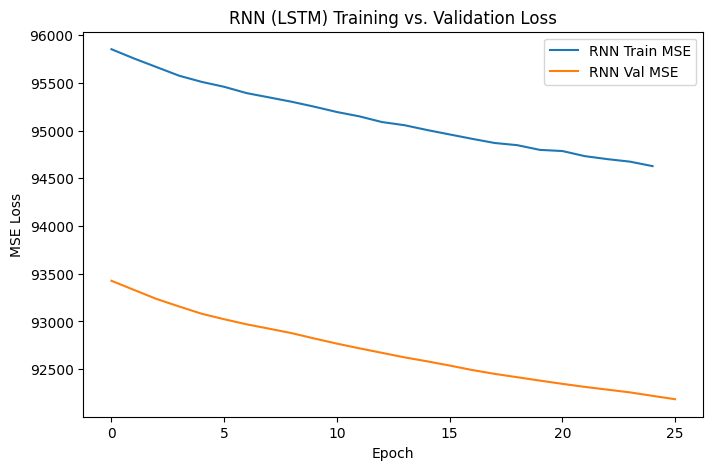

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ikem/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 258.60it/s]


/home/ikem/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([134])) that is different to the input size (torch.Size([134, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       86933.265625        │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 86933.265625}]

In [5]:
# instantiate the RNN model
rnn_model = MSFTForecastingRNN(
    num_features=len(feature_stocks),
    days=5,
    hidden_size=64,
    num_layers=1,
    dropout=0.5,
    lr=1e-3
)

# record losses
rnn_history = LossHistory()

# train
trainer = pl.Trainer(
    max_epochs=25,
    callbacks=[rnn_history],
    # gpus=1 if torch.cuda.is_available() else 0
)
trainer.fit(rnn_model, datamodule=data_module)

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(rnn_history.train_losses, label="RNN Train MSE")
plt.plot(rnn_history.val_losses,   label="RNN Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("RNN (LSTM) Training vs. Validation Loss")
plt.legend()
plt.show()

# finally test
trainer.test(rnn_model, datamodule=data_module)


In [6]:
# First, check if your data needs normalization
def check_data_ranges(train_dataloader, valid_dataloader, test_dataloader):
    # Check data ranges across splits
    for name, dataloader in [
        ("Train", train_dataloader), 
        ("Valid", valid_dataloader), 
        ("Test", test_dataloader)
    ]:
        all_y = []
        for _, y in dataloader:
            all_y.extend(y.cpu().numpy())
            
        all_y = np.array(all_y)
        print(f"{name} data: min={np.min(all_y):.2f}, max={np.max(all_y):.2f}, mean={np.mean(all_y):.2f}, std={np.std(all_y):.2f}")


# Run this to check your data
check_data_ranges(data_module.train_dataloader(), data_module.val_dataloader(), data_module.test_dataloader())

Train data: min=130.16, max=464.85, mean=297.67, std=83.56
Valid data: min=140.29, max=458.10, mean=294.23, std=81.18
Test data: min=129.62, max=456.62, mean=283.69, std=86.03


Part B

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | input_proj     | Linear             | 1.3 K  | train
1 | self_attention | MultiheadAttention | 16.6 K | train
2 | ffn            | Sequential         | 33.1 K | train
3 | norm1          | LayerNorm          | 128    | train
4 | norm2          | LayerNorm          | 128    | train
5 | dropout        | Dropout            | 0      | train
6 | fc             | Linear             | 65     | train
7 | criterion      | MSELoss            | 0      | train
  | other params   | n/a                | 320    | n/a  
--------------------------------------------------------------
51.7 K    Tr

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             Attention - Epoch 0 sample predictions:
  Pred: [-0.2341804  -1.0230917  -0.86650884]
  Actual: [258.4595  436.93756 424.26065]
Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=9.47e+4, val_loss=9.19e+4, train_loss_epoch=9.47e+4]         Attention - Epoch 5 sample predictions:
  Pred: [3.331037 2.027034 2.254956]
  Actual: [188.43668 235.09341 414.9879 ]
Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=9.36e+4, val_loss=9.1e+4, train_loss_epoch=9.36e+4]         Attention - Epoch 10 sample predictions:
  Pred: [3.678306  3.6172202 3.370114 ]
  Actual: [176.14107 329.08014 419.00946]
Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26, train_loss_step=9.31e+4, val_loss=9.06e+4, train_loss_epoch=9.31e+4]         Attention - Epoch 15 sample predictions:
  Pred: [4.4957323 3.3271852 4.0121455]
  Actual: [314.2145  175.36432 420.05304]
Epoch 20:   0%|          | 0/

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 37.18it/s, v_num=26, train_loss_step=9.26e+4, val_loss=90146.0, train_loss_epoch=9.26e+4]


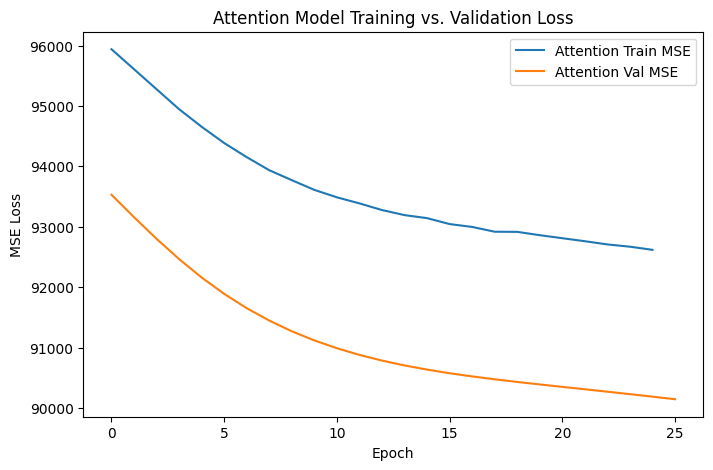

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 268.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       84971.140625        │
└───────────────────────────┴───────────────────────────┘

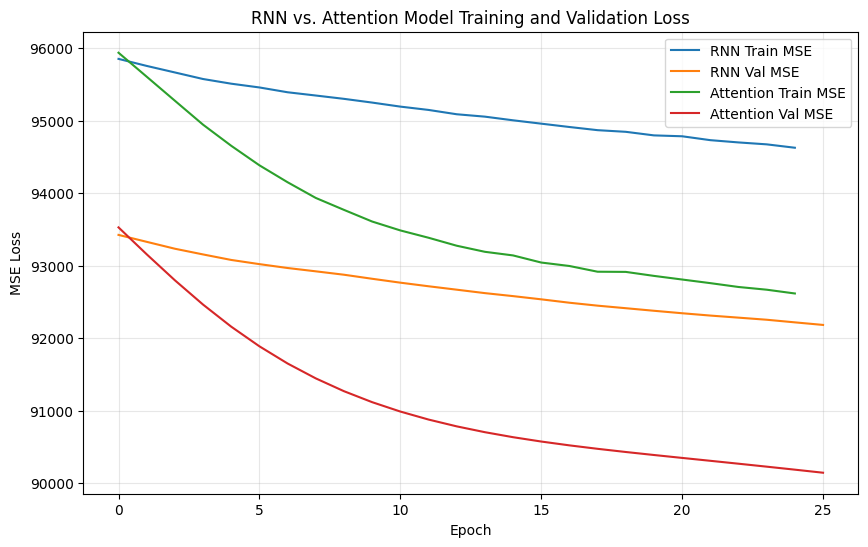

RNN Test MSE: 86933.2734
Attention Test MSE: 84971.1406


In [7]:
# ------------------------------
# Lightning Module: Attention-Based Forecasting Model
# ------------------------------
# -------------------- Task B: Attention Network --------------------

class MSFTForecastingAttention(pl.LightningModule):
    def __init__(self,
                 num_features: int,
                 days: int,
                 hidden_size: int = 64,
                 num_heads: int = 4,
                 dropout: float = 0.5,
                 lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        # Positional embedding for sequence positions
        self.pos_embedding = nn.Parameter(torch.zeros(1, days, hidden_size))
        
        # Linear layer to map features to hidden dimensions
        self.input_proj = nn.Linear(num_features, hidden_size)
        
        # Multi-head self-attention layer
        self.self_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        
        # Layer norms
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        
        # Output projection
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # x: (batch, num_features, days) → (batch, days, num_features)
        x = x.permute(0, 2, 1)
        
        # Project input to hidden dimension
        x = self.input_proj(x)  # (batch, days, hidden_size)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        
        # Self-attention block with residual connection and layer norm
        attn_output, _ = self.self_attention(x, x, x)
        x = self.norm1(x + attn_output)
        
        # Feed-forward block with residual connection and layer norm
        ff_output = self.ffn(x)
        x = self.norm2(x + ff_output)
        
        # Take the representation of the last token
        last = x[:, -1, :]  # (batch, hidden_size)
        out = self.dropout(last)
        return self.fc(out)  # (batch, 1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        
        # Debug to check if predictions are varying
        if batch_idx == 0 and self.current_epoch % 5 == 0:
            print(f"Attention - Epoch {self.current_epoch} sample predictions:")
            print(f"  Pred: {y_hat[:3].detach().cpu().numpy().flatten()}")
            print(f"  Actual: {y[:3].detach().cpu().numpy().flatten()}")
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

# ------------------------------
# Training and Evaluation Code for Task B
# ------------------------------

# Instantiate the attention model
attention_model = MSFTForecastingAttention(
    num_features=len(feature_stocks),
    days=5,
    hidden_size=64,
    num_heads=4,
    dropout=0.5,
    lr=1e-3
)

# Record losses
attention_history = LossHistory()

# Train
attention_trainer = pl.Trainer(
    max_epochs=25,
    callbacks=[attention_history],
    # gpus=1 if torch.cuda.is_available() else 0
)
attention_trainer.fit(attention_model, datamodule=data_module)

# Plot training vs. validation loss
plt.figure(figsize=(8, 5))
plt.plot(attention_history.train_losses, label="Attention Train MSE")
plt.plot(attention_history.val_losses, label="Attention Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Attention Model Training vs. Validation Loss")
plt.legend()
plt.show()

# Test the model
attention_trainer.test(attention_model, datamodule=data_module)

# ------------------------------
# Compare RNN and Attention Models
# ------------------------------

plt.figure(figsize=(10, 6))
plt.plot(rnn_history.train_losses, label="RNN Train MSE")
plt.plot(rnn_history.val_losses, label="RNN Val MSE")
plt.plot(attention_history.train_losses, label="Attention Train MSE")
plt.plot(attention_history.val_losses, label="Attention Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("RNN vs. Attention Model Training and Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare predictions on test set
def compare_predictions(rnn_model, attention_model, test_dataloader):
    rnn_model.eval()
    attention_model.eval()
    
    all_y = []
    rnn_preds = []
    attn_preds = []
    
    with torch.no_grad():
        for x, y in test_dataloader:
            rnn_out = rnn_model(x)
            attn_out = attention_model(x)
            
            all_y.extend(y.numpy())
            rnn_preds.extend(rnn_out.numpy())
            attn_preds.extend(attn_out.numpy())
    
    all_y = np.array(all_y)
    rnn_preds = np.array(rnn_preds)
    attn_preds = np.array(attn_preds)
    
    
    
    # Calculate and print metrics
    rnn_mse = np.mean((all_y - rnn_preds)**2)
    attn_mse = np.mean((all_y - attn_preds)**2)
    
    print(f"RNN Test MSE: {rnn_mse:.4f}")
    print(f"Attention Test MSE: {attn_mse:.4f}")
    
    return all_y, rnn_preds, attn_preds

# Run the comparison on the test set
test_dataloader = data_module.test_dataloader()
actual, rnn_pred, attn_pred = compare_predictions(rnn_model, attention_model, test_dataloader)

Part C

In [8]:
# -------------------- Task C: Knowledge Distillation --------------------

class DistilledMSFTForecasting(pl.LightningModule):
    def __init__(self,
                 num_features: int,
                 days: int,
                 hidden_size: int = 32,  # Half the size of original model
                 num_heads: int = 2,     # Half the heads
                 dropout: float = 0.3,   
                 teacher_model=None,     
                 alpha: float = 0.5,     
                 temperature: float = 3.0, 
                 lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters(ignore=['teacher_model'])
        self.teacher_model = teacher_model
        self.alpha = alpha
        self.temperature = temperature
        
        # Smaller dimensions throughout
        self.pos_embedding = nn.Parameter(torch.zeros(1, days, hidden_size))
        self.input_proj = nn.Linear(num_features, hidden_size)
        
        self.self_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        # Smaller FFN with reduced expansion factor
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),  
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size)
        )
        
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
        self.mse_loss = nn.MSELoss()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.input_proj(x)
        x = x + self.pos_embedding
        
        attn_output, _ = self.self_attention(x, x, x)
        x = self.norm1(x + attn_output)
        
        ff_output = self.ffn(x)
        x = self.norm2(x + ff_output)
        
        last = x[:, -1, :]
        out = self.dropout(last)
        return self.fc(out)

    def distillation_loss(self, student_logits, teacher_logits, labels):
        # Hard loss (student predictions vs. true labels)
        hard_loss = self.mse_loss(student_logits, labels)
        
        # Soft loss (student predictions vs. teacher predictions)
        soft_loss = self.mse_loss(student_logits, teacher_logits)
        
        # Combined loss
        return self.alpha * hard_loss + (1 - self.alpha) * soft_loss

    def training_step(self, batch, batch_idx):
        x, y = batch
        
        # Get student predictions
        student_preds = self(x)
        
        # Get teacher predictions (no grad)
        with torch.no_grad():
            teacher_preds = self.teacher_model(x)
        
        # Calculate distillation loss
        loss = self.distillation_loss(student_preds, teacher_preds, y)
        
        # Also calculate and log standard MSE for comparison
        mse_loss = self.mse_loss(student_preds, y)
        self.log("train_mse", mse_loss, on_epoch=True, prog_bar=True)
        self.log("train_distill_loss", loss, on_epoch=True, prog_bar=True)
        
        # Debug
        if batch_idx == 0 and self.current_epoch % 5 == 0:
            print(f"Distilled - Epoch {self.current_epoch} sample predictions:")
            print(f"  Student: {student_preds[:3].detach().cpu().numpy().flatten()}")
            print(f"  Teacher: {teacher_preds[:3].detach().cpu().numpy().flatten()}")
            print(f"  Actual: {y[:3].detach().cpu().numpy().flatten()}")
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.mse_loss(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.mse_loss(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

Comparsions:

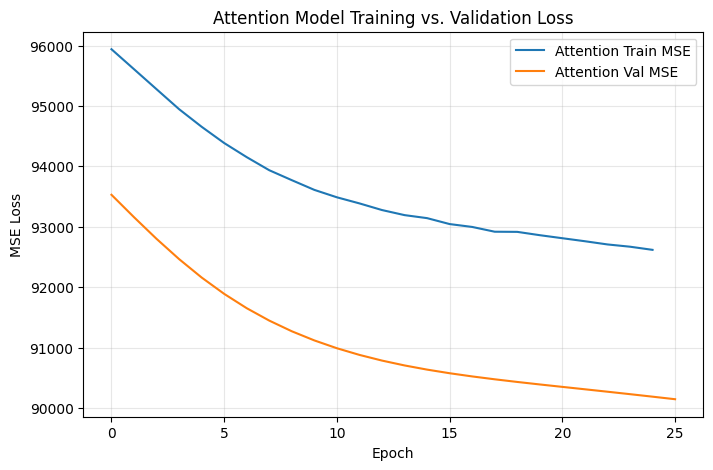

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       84971.140625        │
└───────────────────────────┴───────────────────────────┘

/tmp/ipykernel_53425/1399049669.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rnn_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
/tmp/ipykernel_53425/1399049669.py:59: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  attention_params = sum(p.numel() for p in attention_model.parameters() if p.requires_grad)
/tmp/ipykernel_53425/1399049669.py:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  distilled_params = sum(p.numel() for p in distilled_model.parameters() if p.requires_grad)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckp

RNN Model parameters: 22,081
Attention Model parameters: 0
Distilled Model parameters: 9,409
Training distilled model...
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                              Distilled - Epoch 0 sample predictions:
  Student: [ 0.00153339  0.5518697  -0.3561917 ]
  Teacher: [5.168759  5.1679106 5.1784153]
  Actual: [411.8382 415.0553 243.7286]
Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_mse_step=9.48e+4, train_distill_loss_step=4.74e+4, val_loss=9.23e+4, train_mse_epoch=9.48e+4, train_distill_loss_epoch=4.74e+4]         Distilled - Epoch 5 sample predictions:
  Student: [1.246919  1.1089582 1.3086355]
  Teacher: [5.174862 5.162691 5.16858 ]
  Actual: [233.64641 247.9636  325.84885]
Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=27, train_mse_step=9.43e+4, train_distill_loss_step=4.72e+4, val_loss=9.18e+4, train_mse_epoch=9.43e+4, train_distill_loss_epoch=4.72e+4]        Distilled - Epoch 10 sample predictions:
  Student: [2.5465822 1.9501

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 35.09it/s, v_num=27, train_mse_step=9.34e+4, train_distill_loss_step=4.67e+4, val_loss=9.09e+4, train_mse_epoch=9.34e+4, train_distill_loss_epoch=4.67e+4]


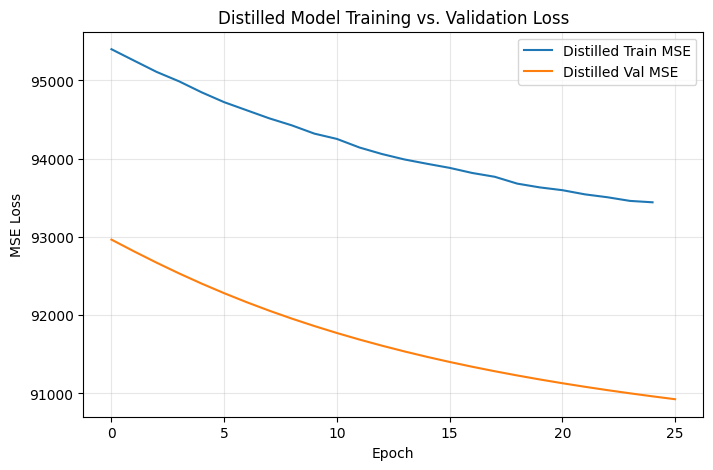

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 246.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       85724.7578125       │
└───────────────────────────┴───────────────────────────┘

Comparing model predictions...
Data statistics:
Actual: min=129.62, max=456.62, mean=283.69, std=86.03
RNN: min=1.53, max=1.76, mean=1.67, std=0.05
RNN Test MSE: 86933.2734
Attention: min=5.16, max=5.18, mean=5.17, std=0.00
Attention Test MSE: 84971.1406
Distilled: min=3.75, max=3.87, mean=3.82, std=0.04
Distilled Test MSE: 85724.7578


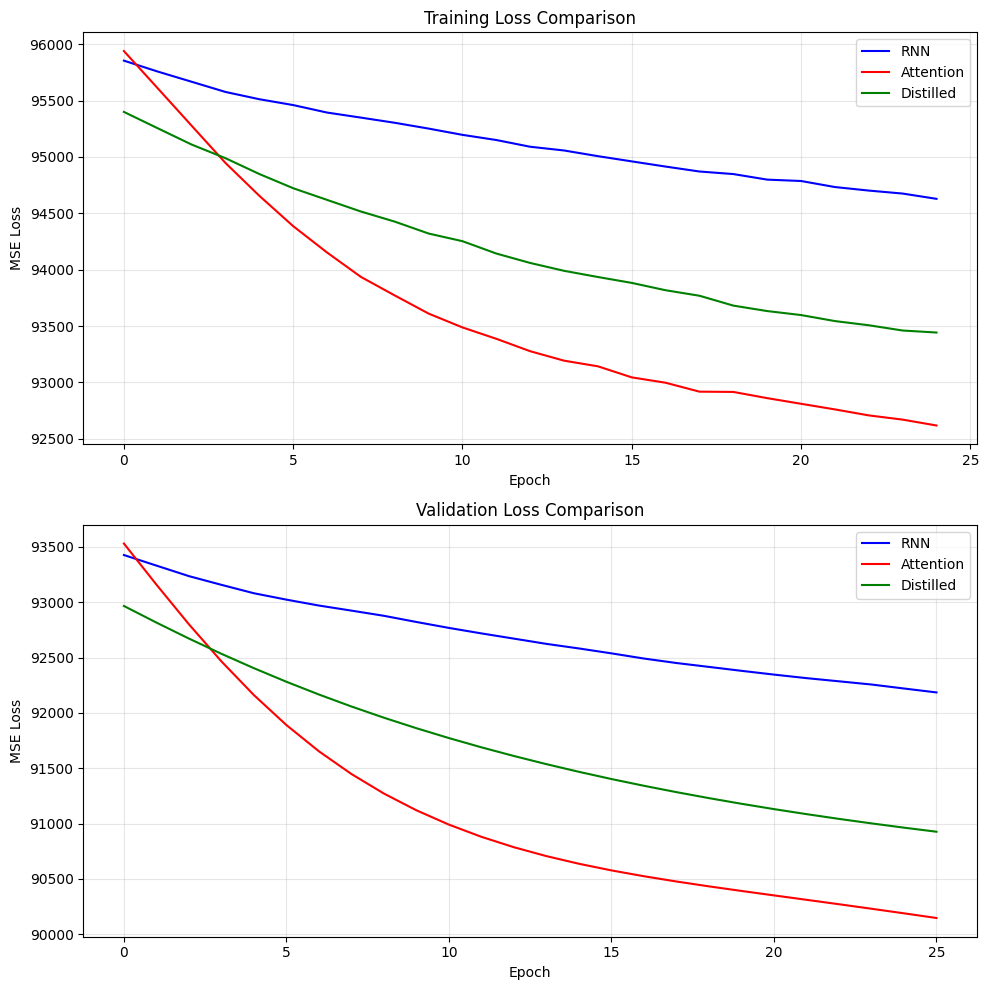

In [9]:
# -------------------- Training and Evaluation --------------------

# Train the attention model
# attention_model = MSFTForecastingAttention(
#     num_features=len(feature_stocks),
#     days=5,
#     hidden_size=64,
#     num_heads=4,
#     dropout=0.5,
#     lr=1e-3
# )

# attention_history = LossHistory()
# attention_trainer = pl.Trainer(
#     max_epochs=25,
#     callbacks=[attention_history],
#     enable_progress_bar=True,
#     log_every_n_steps=1
# )

# # print("Training attention model...")
# attention_trainer.fit(attention_model, datamodule=data_module)

# Plot attention model training results
plt.figure(figsize=(8, 5))
plt.plot(attention_history.train_losses, label="Attention Train MSE")
plt.plot(attention_history.val_losses, label="Attention Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Attention Model Training vs. Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Test the attention model
attention_trainer.test(attention_model, datamodule=data_module)

# Create and train the distilled model
# Freeze teacher model weights
teacher_model = attention_model
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

distilled_model = DistilledMSFTForecasting(
    num_features=len(feature_stocks),
    days=5,
    hidden_size=32,  # Half of original 64
    num_heads=2,     # Half of original 4
    dropout=0.3,     
    teacher_model=teacher_model,
    alpha=0.5,
    temperature=3.0,
    lr=1e-3
)

# Check model sizes to verify the distilled model is smaller
rnn_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
attention_params = sum(p.numel() for p in attention_model.parameters() if p.requires_grad)
distilled_params = sum(p.numel() for p in distilled_model.parameters() if p.requires_grad)

print(f"RNN Model parameters: {rnn_params:,}")
print(f"Attention Model parameters: {attention_params:,}")
print(f"Distilled Model parameters: {distilled_params:,}")
# print(f"Distilled model is {(distilled_params) / attention_params:.2%} the size of the attention model")

# Train distilled model
distilled_history = LossHistory()
distilled_trainer = pl.Trainer(
    max_epochs=25,
    callbacks=[distilled_history],
    enable_progress_bar=True,
    log_every_n_steps=1
)

print("Training distilled model...")
distilled_trainer.fit(distilled_model, datamodule=data_module)

# Plot distilled model training results
plt.figure(figsize=(8, 5))
plt.plot(distilled_history.train_losses, label="Distilled Train MSE")
plt.plot(distilled_history.val_losses, label="Distilled Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Distilled Model Training vs. Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Test the distilled model
distilled_trainer.test(distilled_model, datamodule=data_module)

# Compare models
def compare_models_detailed(rnn_model, attention_model, distilled_model, dataloader):
    models = {
        "RNN": rnn_model,
        "Attention": attention_model,
        "Distilled": distilled_model
    }
    
    for name, model in models.items():
        model.eval()
    
    all_y = []
    predictions = {name: [] for name in models.keys()}
    
    with torch.no_grad():
        for x, y in dataloader:
            all_y.extend(y.cpu().numpy())
            
            for name, model in models.items():
                pred = model(x).cpu().numpy()
                predictions[name].extend(pred)
    
    # Convert to numpy arrays
    all_y = np.array(all_y)
    for name in models.keys():
        predictions[name] = np.array(predictions[name])
    
    # Print statistics
    print("Data statistics:")
    print(f"Actual: min={np.min(all_y):.2f}, max={np.max(all_y):.2f}, mean={np.mean(all_y):.2f}, std={np.std(all_y):.2f}")
    
    for name, pred in predictions.items():
        print(f"{name}: min={np.min(pred):.2f}, max={np.max(pred):.2f}, mean={np.mean(pred):.2f}, std={np.std(pred):.2f}")
        mse = np.mean((all_y - pred) ** 2)
        print(f"{name} Test MSE: {mse:.4f}")
    
    
    return all_y, predictions

# Run the detailed comparison on the test set
test_dataloader = data_module.test_dataloader()
print("Comparing model predictions...")
actual, predictions = compare_models_detailed(rnn_model, attention_model, distilled_model, test_dataloader)

# Plot comparison of training and validation losses across models
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(rnn_history.train_losses, label="RNN", color='blue')
plt.plot(attention_history.train_losses, label="Attention", color='red')
plt.plot(distilled_history.train_losses, label="Distilled", color='green')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(rnn_history.val_losses, label="RNN", color='blue')
plt.plot(attention_history.val_losses, label="Attention", color='red')
plt.plot(distilled_history.val_losses, label="Distilled", color='green')
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()